# Customers Growth Project

## Prologue
The notebook is the combination of the final project of course ELENE6876 in Columbia University and the proposal of a competition I took, aiming to boost customers growth.

## Environment Setup

In [ ]:
pip install surprise

In [ ]:
pip install hmmlearn

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# time format transforming package
from datetime import datetime
from dateutil.relativedelta import *

# text preparation and analysis packages
import re
from collections import Counter
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')

# graph plotting packages
import matplotlib.image as mpimg
from matplotlib import rcParams, cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

# HMM packages
from hmmlearn.hmm import GaussianHMM

# collaborative filtering packages
from surprise import Dataset, Reader, SVD, KNNBasic, accuracy
from surprise.model_selection import cross_validate, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split as sklearn_split

# nlp packages
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

# clustering packages
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

## Data Preprocessing
The data is the customer purchasing history including reviews of Amazon Beauty category, drawn from Julian McAuley's group in UCSD, ```Justifying recommendations using distantly-labeled reviews and fined-grained aspects Jianmo Ni, Jiacheng Li, Julian McAuley Empirical Methods in Natural Language Processing (EMNLP), 2019```

In [ ]:
# load reviews dataset
All_Beauty = pd.read_json(r'./drive/My Drive/Amazon_All_Beauty/All_Beauty.json', lines=True)

# drop irrelevant columns
## 'image' is the url directing to the product image, we would not need it
## since there is 'unixReviewTime', 'reviewTime' could be dropped
## we would not need specific name of the reviewers, so 'reviewerID' is discarded
## 'style' refers to the packaging details like wheather its format, size and color, but only a small portion is non-empty, we drop it
## no description of what 'verified' is, as it has little to do with our project, we discard it
All_Beauty_sub = All_Beauty[['asin', 'overall', 'reviewText', 'reviewerID', 'summary', 'unixReviewTime', 'vote']].copy()

# convert unixReviewTime to datetime and replace the old one
DateTime = All_Beauty_sub.unixReviewTime.apply(lambda x: datetime.fromtimestamp(x)).copy()
All_Beauty_sub['DateTime'] = DateTime
All_Beauty_fin = All_Beauty_sub.drop(columns=['unixReviewTime'])
All_Beauty_fin.head()

,asin,overall,reviewText,reviewerID,summary,vote,DateTime
0,0143026860,1,great,A1V6B6TNIC10QE,One Star,NaN,2015-02-19
1,0143026860,4,My husband wanted to reading about the Negro ...,A2F5GHSXFQ0W6J,... to reading about the Negro Baseball and th...,NaN,2014-12-18
2,0143026860,4,"This book was very informative, covering all a...",A1572GUYS7DGSR,Worth the Read,NaN,2014-08-10
3,0143026860,5,I am already a baseball fan and knew a bit abo...,A1PSGLFK1NSVO,Good Read,NaN,2013-03-11
4,0143026860,5,This was a good story of the Black leagues. I ...,A6IKXKZMTKGSC,"More than facts, a good story read!",5,2011-12-25


In [ ]:
# load meta dataset
meta_All_Beauty = pd.read_json(r'./drive/My Drive/Amazon_All_Beauty/meta_All_Beauty.json', lines=True)

## no description for 'date' and the majority are NaN, probably related to the release date of the product, but it might be useless due to too many empty entries
## 'details' is the url directing to the product page, we would not need it
## 'feature' also has too many empty records, we drop it
## 'image' we do not need it
## 'rank' refers to the rank of the product among the same category, we wouldn't need it
## 'similar item' and 'tech1' refer to other similar products and technological information, we wouldn't need it
## all the products belong to All Beauty so there is no need to include 'main_cat'
meta_All_Beauty_sub = meta_All_Beauty[['also_buy', 'also_view', 'asin', 'brand', 'description', 'price', 'title']].copy()
meta_All_Beauty_sub.head()

,also_buy,also_view,asin,brand,description,price,title
0,NaN,NaN,0061073717,HarperCollins,NaN,NaN,Workout Headphones by Arena Essentials
1,NaN,[B000LXTNMW],0143026860,Swedish Beauty,[This is the NEW PURPLE BOTTLE that just came ...,NaN,Black Diamond
2,"[B00OWT3W28, B010E1X15K, B0796RMSV8, B07HPBWSW...","[B00OWT3W28, B0796RMSV8, B010E1X15K, B010FQJWW...",014789302X,BLUE HEAVE,"[A brand-new, unused, unopened, undamaged item...",$6.45,"12 Pc BLUE HEAVEN KAJAL""HERBAL kajal With VITA..."
3,"[1848426380, B07JVF7M3C, 1644450003, 163557176...","[0571352367, 0573697094, 1635571766, 155936597...",0571348351,Sunatoria,[You have to wonder why there isn't a word in ...,NaN,The Inheritance
4,NaN,NaN,0692508988,Listening Planet,[The Listening Cards are an eloquent primer in...,NaN,The Listening Cards


## Exploratory Data Analysis

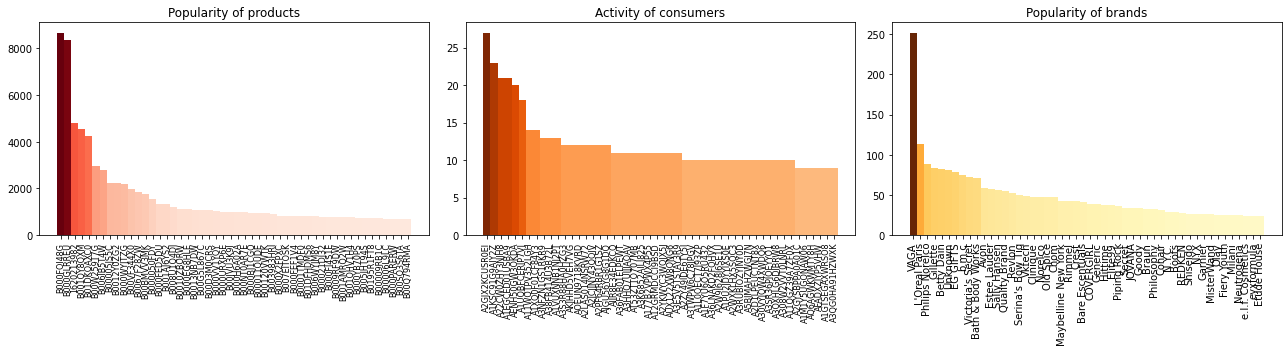

In [ ]:
# define a barplot function
def plot_bar(xfeature, yfeature, xticklabels, title, i, fontsize, color, rotation):
  ax = plt.subplot(1, 3, i);
  ax.bar(xfeature, yfeature, width=1.0, color=color);
  ax.set_xticks(xticklabels)
  ax.set_xticklabels(xticklabels, fontsize=fontsize, rotation=rotation);
  ax.set_title(title)

plt.figure(figsize = (18, 5))
plt.subplot(131);

# Popularity of products
Product = All_Beauty_fin['asin'].value_counts().sort_values(ascending=False)[:50]
colors = cm.Reds(Product / float(max(Product)))
plot_bar(Product.index, Product.values, Product.index, "Popularity of products", 1, 8, colors, 90)

# Activity of consumers
User = All_Beauty_fin['reviewerID'].value_counts().sort_values(ascending=False)[:50]
colors = cm.Oranges(User / float(max(User)))
plot_bar(User.index, User.values, User.index, "Activity of consumers", 2, 8, colors, 90)

# Popularity of brands
Brand = meta_All_Beauty_sub['brand'].value_counts().sort_values(ascending=False)[:50]
colors = cm.YlOrBr(Brand / float(max(Brand)))
plot_bar(Brand.index, Brand.values, Brand.index, "Popularity of brands", 3, 10, colors, 90)

plt.tight_layout()

In [ ]:
# top 2 most popular products
meta_All_Beauty[(meta_All_Beauty_sub.asin == 'B000FOI48G') | (meta_All_Beauty_sub.asin == 'B000GLRREU')]

,title,image,brand,rank,main_cat,asin,description,also_view,also_buy,price,similar_item,details,feature,tech1,date
1343,Waterpik Ultra Water Flosser,[https://images-na.ssl-images-amazon.com/image...,Waterpik,"19,437inBeautyPersonalCare(",All Beauty,B000FOI48G,[Premium dental water jet with dramatically im...,"[B0755JQ4RF, B010NNIZQE, B07H5KV2J1, B01I9TIJQ...","[B003FSTE4W, B001NIZ5U8, B00CU9VF2Q, B0062N798...",NaN,NaN,"\n\n\n\n\n <div class=""disclaim"">Size: <str...",NaN,NaN,NaN
1463,Waterpik Ultra Water Flosser,[https://images-na.ssl-images-amazon.com/image...,Waterpik,"20,356inBeautyamp;PersonalCare(",All Beauty,B000GLRREU,[Premium dental water jet with dramatically im...,"[B0755JQ4RF, B010NNIZQE, B07H5KV2J1, B01I9TIJQ...","[B003FSTE4W, B001NIZ5U8, B00CU9VF2Q, B0062N798...",NaN,NaN,"\n\n\n\n\n <div class=""disclaim"">Size: <str...",NaN,NaN,NaN


*   The top 2 sales are Waterpik Ultra Water Flossers, suggesting that more and more consumers have started to focus on their oral hygiene.







In [ ]:
# Most active customer
All_Beauty[All_Beauty.reviewerID == 'A2GJX2KCUSR0EI'][:1]

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
56187,4,False,"04 24, 2015",A2GJX2KCUSR0EI,B0012XPRO8,Sneaky Burrito,"As a shaving cream, this performs well. It's ...",you'll either love or hate the scent (and it's...,1429833600,NaN,{'Color:': ' Blueberry'},NaN


*   Most of the consumers only bought one products and very few have comnpleted more than 10 purchases, who are likely to be categorized as loyal customers. Mr Sneaky Burrito is the most active consumer with 27 purchases and has been giving positive ratings, indicating his satisfaction with the overall experience.  

In [ ]:
Brand.iloc[0:5]

VAGA               252
L'Oreal Paris      113
Philips Norelco     88
Gillette            83
Betty Dain          82
Name: brand, dtype: int64


*   'VAGA' is the top brand, probably because of its products like scrunchies, nail stamps and makeup brushes, the brand names following are well-known: "L'Oreal Paris", "Philips Norelco" and "Gilette", basically the more categories a brand owns, the more purchases there are and the big brands always attract substantial consumers;

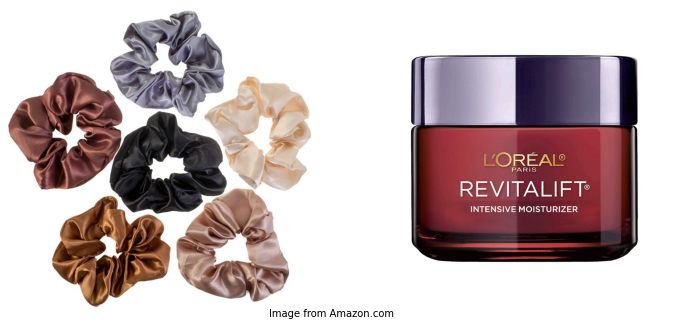

In [ ]:
#@title
rcParams['figure.figsize'] = 12, 12

img_A = mpimg.imread('./drive/My Drive/Amazon_All_Beauty/scrunchies.jpg');
img_B = mpimg.imread("./drive/My Drive/Amazon_All_Beauty/L'Oreal Paris.jpg");
fig, ax = plt.subplots(1, 2);
ax[0].imshow(img_A);
ax[0].axis('off');
ax[1].imshow(img_B);
ax[1].axis('off');
fig.text(0.5, 0.32, 'Image from Amazon.com', ha='center');

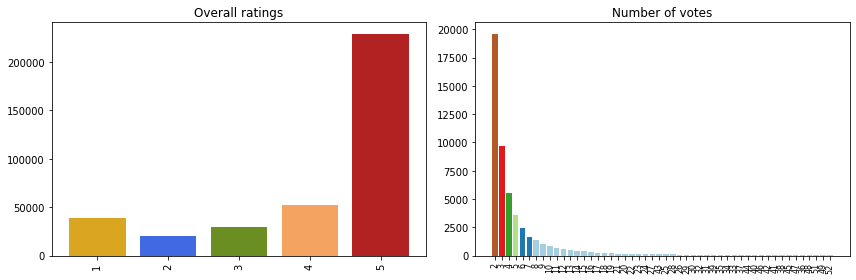

In [ ]:
# define a barplot function
def plot_bar(xfeature, yfeature, xticklabels, title, i, fontsize, color, rotation):
  ax = plt.subplot(1, 2, i);
  ax.bar(xfeature, yfeature, width=0.8, color=color);
  ax.set_xticks(xticklabels)
  ax.set_xticklabels(xticklabels, fontsize=fontsize, rotation=rotation);
  ax.set_title(title)

plt.figure(figsize = (12, 4))
plt.subplot(121);

# Overall ratings
Overall = All_Beauty_fin['overall'].value_counts()
colors = ['firebrick', 'sandybrown', 'goldenrod', 'olivedrab', 'royalblue']
plot_bar(Overall.index, Overall.values, Overall.index, "Overall ratings", 1, 10, colors, 90)

# Number of votes
Vote = All_Beauty_fin['vote'].value_counts().sort_values(ascending=False)[:50]
colors = cm.Paired(Vote / float(max(Vote)))
plot_bar(Vote.index, Vote.values, Vote.index, "Number of votes", 2, 8, colors, 90)

plt.tight_layout()

In [ ]:
# Proportion of 5.0 ratings in all the ratings
(Overall[5] + Overall[4])/sum(Overall)

0.7600371622076506

*   Over 75 percentage are positive feedbacks, people are not tough raters when it comes to beauty products.

In [ ]:
# Proportion of single digit votes
sum(Vote.iloc[0:10])/sum(Vote)

0.9055999374963377

*   The majority of vote numbers are single digit, to some extent consistent with our experience that we always forget to give a vote to the comments we read;


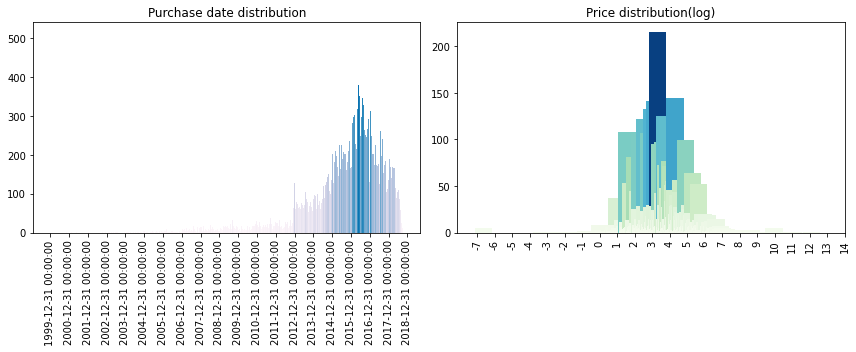

In [ ]:
# define a barplot function
def plot_bar(xfeature, yfeature, xticklabels, title, i, fontsize, color, rotation):
  ax = plt.subplot(1, 2, i);
  ax.bar(xfeature, yfeature, width=1.0, color=color);
  ax.set_xticks(xticklabels)
  ax.set_xticklabels(xticklabels, fontsize=fontsize, rotation=rotation);
  ax.set_title(title)

plt.figure(figsize = (12, 5))
plt.subplot(121);

# Purchase date distribution
DateCount = All_Beauty_fin['DateTime'].value_counts().sort_values(ascending=False)
xticks_range = pd.date_range(start='1/1/1999', end='1/1/2019', freq='Y')
colors = cm.PuBu(DateCount / max(DateCount))
plot_bar(DateCount.index, DateCount.values, xticks_range, "Purchase date distribution", 1, 10, colors, 90)

# Price distribution
Price = meta_All_Beauty_sub['price'].value_counts()
## remove blankspace, comma, dollar sign, range sign and convert into float
Price_no_bls = pd.DataFrame(Price.index)[0].apply(lambda x: x.replace(' ', ''))
Price_no_com = Price_no_bls.apply(lambda x: x.replace(',', ''))
Price_no_sig = Price_no_com.apply(lambda x: x.replace('$', ''))
Price_no_sub = Price_no_sig.copy()
for i in range(len(Price_no_sig)):
  if re.search('-', Price_no_sig.iloc[i]):
    Price_no_sub.iloc[i] = Price_no_sig.iloc[i].split('-')[-1]
  else:
    Price_no_sub.iloc[i] = Price_no_sig.iloc[i]
Price_val = Price_no_sub.apply(lambda x: float(x))
## create a dataframe to store prices and their counts
Price_dict = {'price': Price_val, 'count': Price.values}
Price_df = pd.DataFrame(Price_dict)
## add a column to store log transform of price because there are few extreme values
Price_df['price_log2'] = np.log2(Price_df['price'])
Price_sort = Price_df.sort_values(by=['price_log2'])
colors = cm.GnBu(Price_sort['count'] / max(Price_sort['count']))
plot_bar(Price_sort['price_log2'], Price_sort['count'], range(-7, 15), 'Price distribution(log)', 2, 10, colors, 90)

plt.tight_layout()

*   The data is mainly drawn from records from 2015 to 2017, however it is merely part of the dataset provided by Amazon, no further conclusion could we make on the trend;

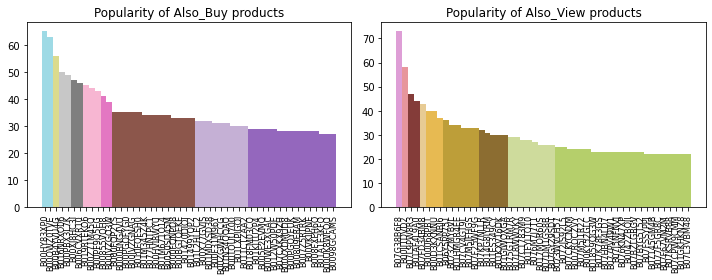

In [ ]:
# define a barplot function
def plot_bar(xfeature, yfeature, xticklabels, title, i, fontsize, color, rotation):
  ax = plt.subplot(1, 2, i);
  ax.bar(xfeature, yfeature, width=1.0, color=color);
  ax.set_xticks(xticklabels)
  ax.set_xticklabels(xticklabels, fontsize=fontsize, rotation=rotation);
  ax.set_title(title)

plt.figure(figsize = (10, 4))
plt.subplot(121);

# Popularity of Also_Buy products
Also_Buy = [] # Create a list to store Also_Buy products
for i in range(len(meta_All_Beauty_sub)):
  if isinstance(meta_All_Beauty_sub['also_buy'].iloc[i], list):
    Also_Buy = Also_Buy + meta_All_Beauty_sub['also_buy'].iloc[i]
# Count the most popular also_buy items
Also_Buy_counts = Counter(Also_Buy)
Top_Also_Buy = Also_Buy_counts.most_common(50)
Top_Also_item = [x[0] for x in Top_Also_Buy]
Top_Also_counts = [x[1] for x in Top_Also_Buy]
colors = cm.tab20(np.array(Top_Also_counts) / max(np.array(Top_Also_counts)))
plot_bar(Top_Also_item, Top_Also_counts, Top_Also_item, "Popularity of Also_Buy products", 1, 8, colors, 90)

# Popularity of Also_View products
Also_View = [] # Create a list to store Also_View products
for i in range(len(meta_All_Beauty_sub)):
  if isinstance(meta_All_Beauty_sub['also_view'].iloc[i], list):
    Also_View = Also_View + meta_All_Beauty_sub['also_view'].iloc[i]
# Count the most popular also_buy items
Also_View_counts = Counter(Also_View)
Top_Also_View = Also_View_counts.most_common(50)
Top_View_item = [x[0] for x in Top_Also_View]
Top_View_counts = [x[1] for x in Top_Also_View]
colors = cm.tab20b(np.array(Top_View_counts) / max(np.array(Top_View_counts)))
plot_bar(Top_View_item, Top_View_counts, Top_View_item, "Popularity of Also_View products", 2, 8, colors, 90)

plt.tight_layout()

In [ ]:
print("Most also_buy products: ", Top_Also_item[:2])
print("Most also_view products: ", Top_View_item[:2])

Most also_buy products:  ['B00HY83XP0', 'B00OWZ0TVE']
Most also_view products:  ['B07G38B6F8', 'B00JITDVD2']


*   The two most also_buy and also_view products are both not existing in the meta data, might from other categories and popular among a wide range of customers, say a best-selling book related to beauty tips.
*   The center of price distribution is around range of 9.99 to 13.99, common prices for general products, the extreme cheap ones have something to do with promotion and very few sells extremely high prices.

In [ ]:
# Do not run this cell!
# Distribution of votes by different scores
Ratings_vote = All_Beauty_fin[['overall', 'vote']].copy()
Ratings_vote['vote'] = Ratings_vote['vote'].fillna(0) # Replace NaN with 0

## remove comma and convert string into int
for i in range(len(Ratings_vote['vote'])):
  if not isinstance(Ratings_vote['vote'].iloc[i], int):
    Ratings_vote['vote'].iloc[i] = Ratings_vote['vote'].iloc[i].replace(',', '')
Ratings_vote['vote'] = Ratings_vote['vote'].astype(int)

## add a column to indicate log10 vote
Ratings_vote['vote_log10'] = np.log10(Ratings_vote['vote'] + 1)

# add columns to store the weekday and month of each datetime
WeekDay = [x.weekday() for x in All_Beauty_fin['DateTime']]
Month = [x.month for x in All_Beauty_fin['DateTime']]
All_Beauty_fin['WeekDay'] = WeekDay
All_Beauty_fin['Month'] = Month

# add a column to store the corresponding price for products
meta_All_Beauty_subs = meta_All_Beauty_sub.dropna(subset=['price'])
PriceNoBls = meta_All_Beauty_subs['price'].apply(lambda x: x.replace(" ", ""))
PriceNoCom = PriceNoBls.apply(lambda x: x.replace(',', ''))
PriceNoSig = PriceNoCom.apply(lambda x: x.replace('$', ''))
PriceNoSub = PriceNoSig.copy()
for i in range(len(PriceNoSig)):
  if re.search('-', PriceNoSig.iloc[i]):
    PriceNoSub.iloc[i] = PriceNoSig.iloc[i].split('-')[-1]
  else:
    PriceNoSub.iloc[i] = PriceNoSig.iloc[i]
PriceVal = PriceNoSub.apply(lambda x: float(x))
meta_All_Beauty_subs['price_value'] = PriceVal

cor_val = []
for i in range(len(All_Beauty_fin)):
  if meta_All_Beauty_subs[meta_All_Beauty_subs['asin'] == All_Beauty_fin['asin'].iloc[i]]['price'].empty:
    cor_val.append(np.NaN)
  else:
    cor_val.append(meta_All_Beauty_subs[meta_All_Beauty_subs['asin'] == All_Beauty_fin['asin'].iloc[i]]['price_value'].values[0])
All_Beauty_fin['price_value'] = cor_val
All_Beauty_fin.to_pickle('./drive/My Drive/Amazon_All_Beauty/All_Beauty_fin.pkl')
All_Beauty_final = All_Beauty_fin.dropna(subset=['price_value']).copy()

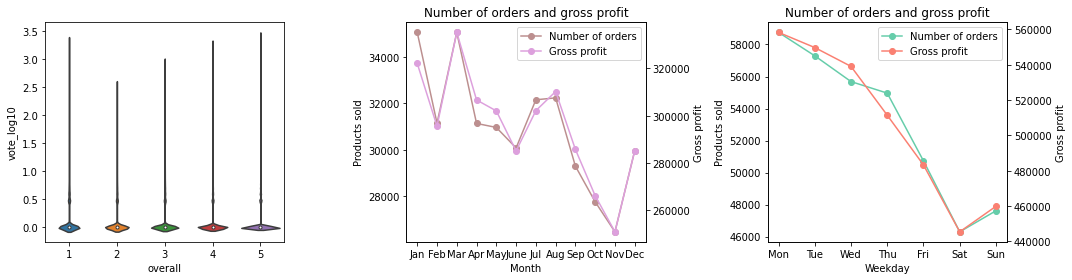

In [ ]:
# Distribution of votes by different scores
plt.figure(figsize=(15,4))
plt.subplot(131)
ax = plt.subplot(1, 3, 1)
ax = sns.violinplot(x="overall", y="vote_log10", data=Ratings_vote)

# Number of orders and the gross profit in each month
NumOfOrders = All_Beauty_fin.groupby(by=['Month']).count()['asin']
GrossProfit = All_Beauty_final.groupby(by=['Month']).sum()['price_value']

ax1 = plt.subplot(1, 3, 2)
ax1.set_xlabel('Month')
ax1.set_ylabel('Products sold')
ax1.plot(NumOfOrders.keys(), NumOfOrders.values, '-o', color = 'rosybrown', label='Number of orders')
ax1.set_xticks(list(range(1, 13)));
ax1.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax1.set_title("Number of orders and gross profit");
ax1.set_ylabel("Products sold");

ax2 = ax1.twinx()
ax2.set_ylabel('Gross profit')
ax2.plot(GrossProfit.keys(), GrossProfit.values, '-o', color = 'plum', label = 'Gross profit');

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='upper right')

# Number of orders and the gross profit in each weekday
OrdersWD = All_Beauty_fin.groupby(by=['WeekDay']).count()['asin']
GrossProfitWD = All_Beauty_final.groupby(by=['WeekDay']).sum()['price_value']

ax1 = plt.subplot(1, 3, 3)
ax1.set_xlabel('Weekday')
ax1.set_ylabel('Products sold')
ax1.plot(OrdersWD.keys(), OrdersWD.values, '-o', color = 'mediumaquamarine', label = 'Number of orders')
ax1.set_xticks(range(0, 7));
ax1.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
ax1.set_title("Number of orders and gross profit");
ax1.set_ylabel("Products sold");

ax2 = ax1.twinx()
ax2.set_ylabel('Gross profit')
ax2.plot(GrossProfitWD.keys(), GrossProfitWD.values, '-o', color = 'salmon', label = 'Gross profit');

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='upper right')

plt.tight_layout()

*   Although there are merely single-digit votes for the majority of reviews, the highest vote numbers for score 2 and 3 are significantly lower than that of score 1 and 5, probably because people prefer to read the extreme-rating reviews and the reviewers always give sound reasons for negative or positive feedbacks, in the example below, the poor rating is due to the unfit size and the good one gives credit to the fragrance.

In [ ]:
# review of score 1
print("score 1: " + All_Beauty_final.iloc[90894]['reviewText'])

# review of score 5
print("score 5: " + All_Beauty_final.iloc[134223]['reviewText'])

score 1: I have average size hands and they were still a little large. Would not recommend for small hands. I turned them inside out and sewed the fingers so that they were tighter. Then they worked much better.
score 5: very good smell, i love them


*   There are two peaks during the year, one in the begin of the year and the other in the end, the first one likely related to the festivals and rising activities near the spring break and the later one related to shopping for the Christmas. 
*   The orders number and gross profit demonstrate a decreasing trend throughout the week, since it is the review dataset, the reason might be that people are used to finish the reviews in their spare time on weekdays instead of weekends when they could spend on other meaningful events. 



In [ ]:
# Do not run this cell! add a column to indicate the product brand for each transaction
cor_brd = []
for i in range(len(All_Beauty_fin)):
  if meta_All_Beauty_sub[meta_All_Beauty_sub['asin'] == All_Beauty_fin['asin'].iloc[i]]['brand'].empty:
    cor_brd.append(np.NaN)
  else:
    cor_brd.append(meta_All_Beauty_sub[meta_All_Beauty_sub['asin'] == All_Beauty_fin['asin'].iloc[i]]['brand'].values[0])
All_Beauty_fin['brand'] = cor_brd
All_Beauty_fin.to_pickle('./drive/My Drive/Amazon_All_Beauty/All_Beauty_final.pkl')

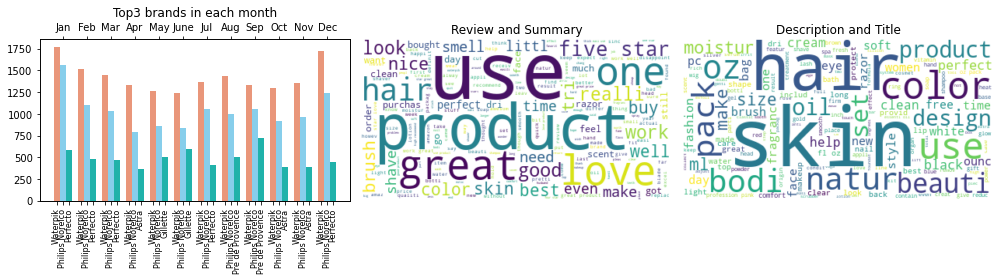

In [ ]:
plt.figure(figsize=(14,4))
plt.subplot(131)
# Define a parser and wordcloud plot function
def parser(unparsed_text):
  parsed_text = []
  for sent in unparsed_text:
    sent = str(sent)
    if len(sent.split()) < 300:
        sent = sent.lower()
        sent = re.sub(r'\d+', '', sent)
        sent = re.sub(r'[^\w]', ' ', sent)
        sent = re.sub(' +', ' ', sent)
        parsed_text.append(sent)
  return parsed_text

## Remove stopwords and keep the stem of words
Stopwords = set(stopwords.words('english'))
Stemmer = nltk.stem.SnowballStemmer('english')
def plot_wordcloud(parsed_text, title, i):
  text = ''
  for sent in parsed_text:
    for word in sent.split():
      if word not in Stopwords:
        text = text + ' ' + Stemmer.stem(word)
  wordcloud = WordCloud(background_color='white').generate(text)
  ax = plt.subplot(1, 3, i)
  ax.imshow(wordcloud, interpolation='bilinear', aspect='auto')
  ax.axis('off')
  ax.set_title(title)

# Top3 brands in each month
All_Beauty_final = pd.read_pickle('./drive/My Drive/Amazon_All_Beauty/All_Beauty_final.pkl')

## Select top 3 brands in each month
Month_brand = All_Beauty_final[['Month', 'brand']].copy()
Month_brand = Month_brand.dropna(subset=['brand'])
Month_Top3 = Month_brand.groupby('Month')['brand'].apply(lambda x: x.value_counts().head(3))
brand_keys = [x[1] for x in Month_Top3.keys()]

## Plot histogram of brands in each month
Month_Top3_flat = Month_Top3.reset_index(level=[1])
Brand1 = [Month_Top3_flat.iloc[3*n]['brand'] for n in range(12)]
Brand2 = [Month_Top3_flat.iloc[3*n + 1]['brand'] for n in range(12)]
Brand3 = [Month_Top3_flat.iloc[3*n + 2]['brand'] for n in range(12)]
Brand1_name = [brand_keys[3*n] for n in range(12)]
Brand2_name = [brand_keys[3*n + 1] for n in range(12)]
Brand3_name = [brand_keys[3*n + 2] for n in range(12)]

n_groups = 12
ax = plt.subplot(1, 3, 1)
index = np.arange(12)
bar_width = 0.25
Brand1_plt = ax.bar(index - bar_width, Brand1, bar_width, color = 'darksalmon', label = 'Top1')
Brand2_plt = ax.bar(index, Brand2, bar_width, color = 'skyblue', label = 'Top2')
Brand3_plt = ax.bar(index + bar_width, Brand3, bar_width, color = 'lightseagreen', label = 'Top3')
index_all = np.concatenate([index-bar_width, index, index+bar_width])
ax.set_xticks(index_all);
ax.set_xticklabels(Brand1_name+Brand2_name+Brand3_name, rotation=90, fontsize=8);
ax.set_title("Top3 brands in each month");
ax_m = ax.twiny()
ax_m.set_xlim(ax.get_xlim())
ax_m.set_xticks(index);
ax_m.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']);

## Concatenate reviewText and summary
All_Beauty_final['review_summary'] = All_Beauty_final['reviewText'] + All_Beauty_final['summary']

## Wordcloud of review and summary
unparsed_RevSum = All_Beauty_final.sample(frac=0.02, replace=False, random_state=0)['review_summary']
parsed_RevSum = parser(unparsed_RevSum)
plot_wordcloud(parsed_RevSum, 'Review and Summary', 2)

## Concatenate description and title
description = []
for desc in meta_All_Beauty_sub['description']:
  try: 
    desc = desc[0]
    description.append(desc)
  except:
    description.append('')
meta_All_Beauty_sub['description'] = description
meta_All_Beauty_sub['desc_title'] = meta_All_Beauty_sub['description'] + meta_All_Beauty_sub['title']

meta_All_Beauty_final = meta_All_Beauty_sub[['asin', 'brand', 'price', 'desc_title']].copy()
pd.to_pickle(meta_All_Beauty_final, "./drive/My Drive/Amazon_All_Beauty/meta_All_Beauty_final.pkl")

## Wordcloud of description and title
unparsed_meta = meta_All_Beauty_sub.sample(frac=0.02, replace=False, random_state=0)['desc_title']
parsed_meta = parser(unparsed_meta)
plot_wordcloud(parsed_meta, 'Description and Title', 3)

plt.tight_layout()

*   The top2 brands throughout the year are always 'Waterpik' and 'Philips Norelco', consistent with the fact that the daily demands for flossers and shavers would not change much with time; 'Perfecto', 'Astra' and 'Gillette' stay on the top3 and they are all brands related to shavers, probably because the majority of the gathered data is drawn from male customers.





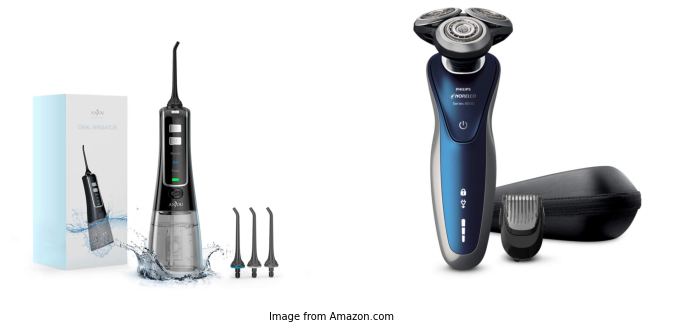

In [ ]:
#@title
rcParams['figure.figsize'] = 12, 12

img_A = mpimg.imread('./drive/My Drive/Amazon_All_Beauty/Waterpik.jpg');
img_B = mpimg.imread('./drive/My Drive/Amazon_All_Beauty/Philips Norelco.jpg');
fig, ax = plt.subplots(1, 2);
ax[0].imshow(img_A);
ax[0].axis('off');
ax[1].imshow(img_B);
ax[1].axis('off');
fig.text(0.5, 0.32, 'Image from Amazon.com', ha='center');

*   Reviews and summaries are generally focused on the utility of the products and consumers are willing to give positive feedbacks by leaving words like 'love' and 'great'
    *   ***Very well*** built ***product***  -  ***Use*** & enjoy it every day.
    *   I bought this for my boyfriend and he absolutely ***loved*** it thanks for a **great product**
*   The descriptions and titles are mainly related to sub categories like 'body', 'skin', 'hair' and the volumes like 'oz', 'ml' or characteristics like 'black', 'moisture', 'beauty'
    *   BodyLift Firming ***Body*** Lotion - 7 fl oz
    *   DPhisoderm Deep Cleaning Cleanser, Sensitive ***Skin***, 14 Ounces
    *   Nature's Plus - Ultra ***Hair***, 60 tablets
    *   WTe Tao Soothing Shampoo , 8.4 fl ***oz*** (248 ***ml***).
    *   Clairol mens choice natural looking haircolor, Natural ***black***, M44 - 1 kit
    *   5Lever 2000 Antibacterial ***Moisturizing*** Wipes, Travel Size (15 Wipes)
    *   U-***beauty*** New High Quality 20 Colors Concealer Eyeshadow Palette Makeup





## Customer Segmentation

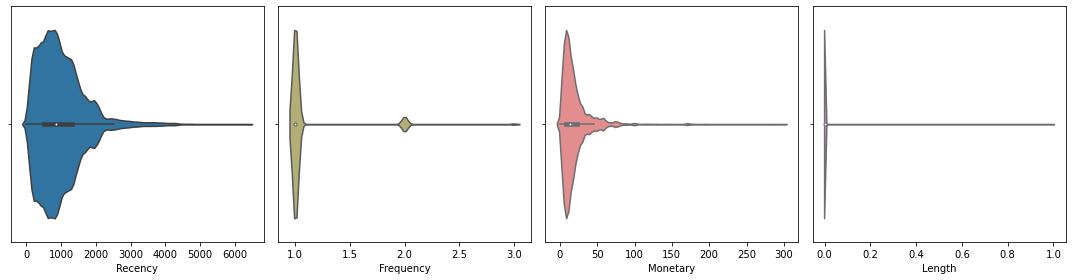

In [ ]:
# delete rows without price since it is impossible to calculate the total expenditure
All_Beauty_seg = All_Beauty_final.dropna(subset=['price_value'])

# set the latest time as the current date
Latest_time = All_Beauty_seg['DateTime'].max()

# create dataframe to record the first and last date each customer purchase
df_recency = All_Beauty_seg.groupby(by='reviewerID', as_index=False)['DateTime'].min()
df_recency['LastDate'] = (All_Beauty_seg.groupby(by='reviewerID', as_index=False)['DateTime']).max()['DateTime']
df_recency.columns = ['reviewerID', 'FirstDate', 'LastDate']

# add a column to record calculated recency
Recency = Latest_time - df_recency['LastDate']
Recency_days = [Day.days for Day in Recency]
df_recency['Recency'] = Recency_days

# add a column to record calculated length
Length = df_recency['LastDate'] - df_recency['FirstDate']
Length_days = [Day.days for Day in Length]
df_recency['Length'] = Length_days

# create dataframe to record the frequency of purchases
df_frequency = All_Beauty_seg[['reviewerID', 'asin']].groupby(by='reviewerID', as_index=False)['asin'].count()

# create dataframe to record the monetary
df_monetary = All_Beauty_seg[['reviewerID', 'price_value']].groupby(by='reviewerID', as_index=False)['price_value'].sum()

# ensemble the dataframes into the final RFM dataframe
df_RFML = pd.DataFrame(columns=[])
df_RFML['reviewerID'] = df_recency['reviewerID']
df_RFML['Recency'] = df_recency['Recency']
df_RFML['Frequency'] = df_frequency['asin']
df_RFML['Monetary'] = df_monetary['price_value']
df_RFML['Length'] = df_recency['Length']
df_RFML.set_index('reviewerID', inplace=True, drop=True)

# distribution of the 4 attributes
plt.figure(figsize=(15, 4))
ax1 = plt.subplot(1, 4, 1)
ax1 = sns.violinplot(x = df_RFML['Recency'])
ax2 = plt.subplot(1, 4, 2)
ax2 = sns.violinplot(x=df_RFML[df_RFML['Frequency'] < 4]['Frequency'], color='darkkhaki')
ax3 = plt.subplot(1, 4, 3)
ax3 = sns.violinplot(x = df_RFML[df_RFML['Monetary'] < 300]['Monetary'], color='lightcoral')
ax4 = plt.subplot(1, 4, 4)
ax4 = sns.violinplot(x=df_RFML[df_RFML['Length'] < 2]['Length'], color='violet')
plt.tight_layout()

*   The recency gathers around 1000, suggesting that the majority of customers complete their last transactions 3 years ago, the part near 0 is what we consider to be the most valuable ones;
*   Distribution of frequency shows a knot in frequency 2 meaning that a small portion would return for second purchase, strategy should be applied to retain this kind of consumers and only few are extremely loyal customers 2-digit frequency;
*   Most of monetary concentrate below 50 consistent with our exploration prices are generally 9.99 ~ 13.99 and frequency no more than 2;
*   Over 97% lengths are 0 as frequencies are mainly 1.

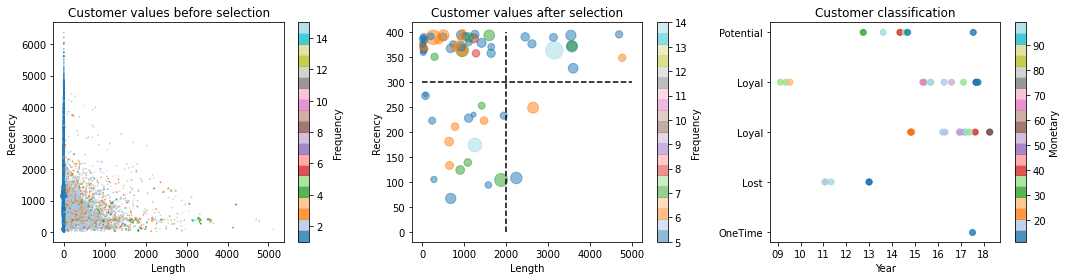

In [ ]:
# visualize customer values based on RFML
fig, axes = plt.subplots(1, 3, figsize=(15, 4));
Customer_values = axes[0].scatter(df_RFML['Length'], df_RFML['Recency'], s=df_RFML['Monetary']*1e-2, c=df_RFML['Frequency'], alpha=.8, cmap='tab20');
axes[0].set_xlabel('Length');
axes[0].set_ylabel('Recency');
axes[0].set_title('Customer values before selection');
values_cbar = fig.colorbar(Customer_values, ax=axes[0])
values_cbar.set_label('Frequency')

# select the part we are concerned with
df_selected = df_RFML[(df_RFML['Recency'] < 400) & (df_RFML['Frequency'] > 4) & (df_RFML['Monetary'] > 10) & (df_RFML['Length'] > 0)]
Customer_values = axes[1].scatter(df_selected['Length'], df_selected['Recency'], s=df_selected['Monetary'], c=df_selected['Frequency'], alpha=.5, cmap='tab20');
axes[1].hlines(300, xmin=0, xmax=5000, linestyles='dashed', colors='k')
axes[1].vlines(2000, ymin=0, ymax=400, linestyles='dashed', colors='k')
axes[1].set_xlabel('Length');
axes[1].set_ylabel('Recency');
axes[1].set_title('Customer values after selection');
values_cbar = fig.colorbar(Customer_values, ax=axes[1])
values_cbar.set_label('Frequency')

# Classify customers by RFML
OneTime_Customer = All_Beauty_seg[All_Beauty_seg['reviewerID'] == 'A13PV955ZZEQFC']
Lost_Customer = All_Beauty_seg[All_Beauty_seg['reviewerID'] == 'AA83QXB39NF8B']
Potential_Customer = All_Beauty_seg[All_Beauty_seg['reviewerID'] == 'A1TPW86OHXTXFC']
Loyal_Customer = All_Beauty_seg[All_Beauty_seg['reviewerID'] == 'A1KSC91G9AIY2Z']
Loyal_Customer2 = All_Beauty_seg[All_Beauty_seg['reviewerID'] == 'A22CW0ZHY3NJH8']

# visualize customer classification
Customer_comp = axes[2].scatter(OneTime_Customer['DateTime'], [1]*len(OneTime_Customer), c=OneTime_Customer['price_value'], alpha=.8, cmap='tab20');
Customer_comp = axes[2].scatter(Lost_Customer['DateTime'], [2]*len(Lost_Customer), c=Lost_Customer['price_value'], alpha=.8, cmap='tab20');
Customer_comp = axes[2].scatter(Loyal_Customer['DateTime'], [3]*len(Loyal_Customer), c=Loyal_Customer['price_value'], alpha=.8, cmap='tab20');
Customer_comp = axes[2].scatter(Loyal_Customer2['DateTime'], [4]*len(Loyal_Customer2), c=Loyal_Customer2['price_value'], alpha=.8, cmap='tab20');
Customer_comp = axes[2].scatter(Potential_Customer['DateTime'], [5]*len(Potential_Customer), c=Potential_Customer['price_value'], alpha=.8, cmap='tab20');
axes[2].set_xticklabels(['08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18'])
axes[2].set_yticks(range(1, 6))
axes[2].set_yticklabels(['OneTime', 'Lost', 'Loyal', 'Loyal', 'Potential']);
axes[2].set_xlabel('Year');
axes[2].set_title('Customer classification');
comp_cbar = fig.colorbar(Customer_comp, ax = axes[2]);
comp_cbar.set_label('Monetary');

plt.tight_layout()

*   It is not worth to invest on all the customers with equal efforts as a high ratio of them would seldom respond to the advertisements or campaigns, for instance over 92% One-time customer is not likely to return to the market at all, since there are other choices like other websites or brick and mortar shops.
*   Instead, it is more reasonable to target those loyal and potential customers who either has been used to purchasing on our website or is inclined to becoming a loyal one, in the first figure, customers at the right corner with bigger size and darker color are who we should be concerned about.
*   In the 2nd figure, the upper left corner is the group with relatively short member lifetime and have not completed any purchase in the recent year, to wake up them, strong stimulus like coupons or gifts would probably work; the upper right are those who had spent extended time on our platform but unfortunately we lost, customized services like phone calls or special visits might be more effective since they had sustained the membership for such a long period, it is vital to make them feel cared about; the down right are young generation of customers who became the member short time ago but have been active in recent years, with potential to turn into loyals.

## Purchase prediction

### Poisson Process

In [ ]:
df_selected['predict_DateTime'] = 0

# predict the datetime of next purchase
All_Beauty_DateTime = All_Beauty_seg[['reviewerID', 'DateTime']].copy()
All_Beauty_DateTime.loc[371345] = ['Latest_time', Latest_time]
year_month = pd.to_datetime(All_Beauty_DateTime['DateTime']).dt.to_period('M').astype(int)
All_Beauty_DateTime['year_month'] = year_month
Latest_month = All_Beauty_DateTime.loc[371345]['year_month']
months_in_year = 12
for idx in range(len(df_selected)):
  Customer_hist = All_Beauty_DateTime[All_Beauty_DateTime['reviewerID'] == df_selected.index[idx]]
  Customer_sort = Customer_hist.sort_values(by=['DateTime'])
  purchase_per_month = len(Customer_sort) / (Latest_month - Customer_sort.iloc[0]['year_month'] + 1)
  purchase_predict = np.random.choice([0, 1], size=100*months_in_year, replace=True, p=[1-purchase_per_month, purchase_per_month])
  months_to_come = np.where(purchase_predict==1)[0][0]
  predict_DateTime = Latest_time + relativedelta(months = months_to_come + 1)
  df_selected['predict_DateTime'].iloc[idx] = predict_DateTime

# extract history data and prediction from selected customers
DateTime_selected = []
for idx in df_selected.index:
  DateTime_selected = DateTime_selected + list(All_Beauty_DateTime[All_Beauty_DateTime['reviewerID'] == idx]['DateTime'])
DateTime_count = pd.Series(DateTime_selected).value_counts()
prediction_count = df_selected['predict_DateTime'].value_counts()

# randomly pick a customer and visualize the prediction result
RandomCustomer = All_Beauty_DateTime[All_Beauty_DateTime['reviewerID'] == 'A1XCSAX4BRT89Y']
RandomCustomer_sort = RandomCustomer.sort_values(by=['DateTime'])
print('Customer id:', All_Beauty[All_Beauty.reviewerID == 'A1AEPMPA12GUJ7']['reviewerName'].iloc[0])
brands = []
titles = []
for idx in RandomCustomer_sort.index:
  brands.append(All_Beauty_seg.loc[idx]['brand'])
  idx_asin = All_Beauty_seg.loc[idx]['asin']
  titles.append(meta_All_Beauty[meta_All_Beauty.asin == idx_asin]['title'].values[0])
RandomCustomer_sort['brand'] = brands
RandomCustomer_sort['title'] = titles
RandomCustomer_sort

Customer id: Glenda Boozer


,reviewerID,DateTime,year_month,brand,title
42516,A1XCSAX4BRT89Y,2015-02-20,541,NaN,SK-II Facial Treatment Essence
192341,A1XCSAX4BRT89Y,2017-09-05,572,Pre de Provence,Pre de Provence Artisanal French Soap Bar Enri...
54859,A1XCSAX4BRT89Y,2017-09-16,572,Urban Spa,Urban Spa Moisturizing Booties to Keep your Fe...
63384,A1XCSAX4BRT89Y,2017-09-16,572,Urban Spa,Urban Spa Moisturizing Booties to Keep your Fe...
79142,A1XCSAX4BRT89Y,2017-10-03,573,Pre de Provence,Pre de Provence Maison French Dried Lavender B...
192127,A1XCSAX4BRT89Y,2017-10-03,573,Pre de Provence,Pre de Provence Artisanal French Soap Bar Enri...
225665,A1XCSAX4BRT89Y,2017-10-03,573,Pre de Provence,Pre De Provence Maison French Lavender Bath & ...


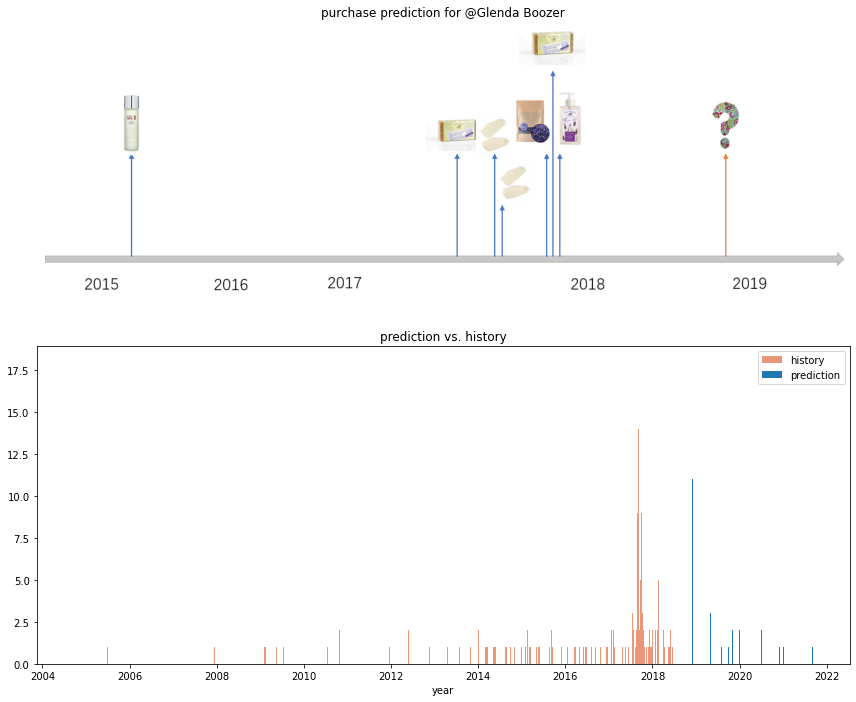

In [ ]:
#@title
rcParams['figure.figsize'] = 12, 12

img_A = mpimg.imread('./drive/My Drive/Amazon_All_Beauty/visualization.PNG');
fig, axes = plt.subplots(2, 1, figsize=(12, 10));
axes[0].imshow(img_A);
axes[0].axis('off');
axes[0].set_title('purchase prediction for @Glenda Boozer');

axes[1].bar(DateTime_count.index, DateTime_count.values, width=5, color='darksalmon', label='history');
axes[1].bar(prediction_count.index, prediction_count.values, width=5, label='prediction');
axes[1].set_xlabel('year');
axes[1].set_title('prediction vs. history')
axes[1].legend();

plt.tight_layout()

The purchase behavior of a single customer could modeled as a poisson process that happens randomly but has a constant average rate:
$P(k purchases in time period) = e^-\frac{purchases}{time}*time period*\frac{(\frac{purchases}{time}*time period)^k}{k!} = e^-\lambda\frac{\lambda^k}{k!}$ where $\lambda$ stands for the expected purchases in the time period.
*   Take ***@Glenda Boozer*** as an example, leave the last two record out as validation set, $\lambda = \frac{purchases}{time}*time period = \frac{5}{573-541+1} * 12 = 1.82$, indicating that the average purchases after 2017-10 would be about 2, consistent with the validation data. 
*   The probability of waiting time tells us possible time customer takes until the next order: $P(T \leq t) = 1 - e^-\frac{purchases}{time}*t = 1 - e^-\frac{5}{573-541+1} * 6 = 0.60$, suggesting that the customer is expected to complete at least one purchase in the next half year.
*   To simulate the waiting time, 0 and 1 is sampled according to their probability, namely $[1 - \frac{purchases}{time}, \frac{purchases}{time}]$ in our case.
*   ***@Glenda Boozer*** completed her first order in early 2015 then stayed inactive for more than 2 years, but intensively bought 6 products on September and October in 2017, the intervals between purchases are in a random pattern but there is always probability that the next transaction is about to happen, thus it would be helpful to predict the following active time with poisson distribution.
*   It is a good sign that most of the predicted dates are near the 'current date' meaning large part of the customers would continue their purchases on our website, only a fraction are predicted to wait until 2022 to return corresponding to the ones with long recency.

### Hidden Markov Model





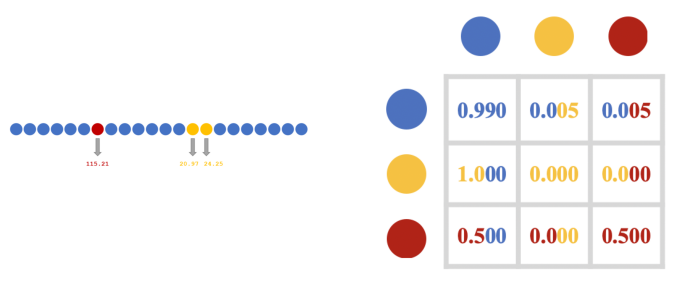

In [ ]:
#@title
rcParams['figure.figsize'] = 12, 12

img_A = mpimg.imread('./drive/My Drive/Amazon_All_Beauty/MC.PNG');
img_B = mpimg.imread('./drive/My Drive/Amazon_All_Beauty/TM.png');
fig, ax = plt.subplots(1, 2);
ax[0].imshow(img_A);
ax[0].axis('off');
ax[1].imshow(img_B);
ax[1].axis('off');

In [ ]:
min_month = All_Beauty_seg['DateTime'].dt.to_period('M').astype(int).min() ## set min and max month in the entire dataset
max_month = All_Beauty_seg['DateTime'].dt.to_period('M').astype(int).max()

GB_history = All_Beauty_seg[All_Beauty_seg['reviewerID'] == 'A1XCSAX4BRT89Y'][['DateTime', 'price_value']].copy() ## add a column to record the month
GB_history['MonthTime'] = GB_history['DateTime'].dt.to_period('M').astype(int)

MC = np.zeros(max_month-min_month+1) ## create a Markov Chain to represent customers' expenses
for i in range(len(GB_history.index)):
  MC[GB_history.iloc[i]['MonthTime']-min_month] = GB_history[GB_history['MonthTime'] == GB_history.iloc[i]['MonthTime']]['price_value'].sum()

model = GaussianHMM(n_components=3, covariance_type='full', n_iter=100).fit(MC.reshape(MC.shape[0], 1)) ## train the HMM with consumption values 
hidden_states = model.predict(MC.reshape(MC.shape[0], 1)) ## obtain the hidden states
print('transition matrix:\n', model.transmat_)
pred_month = np.random.choice([0, 1, 2], size=100, replace=True, p=model.transmat_[0]) ## predict the next state according to transition matrix
print('hidden states to come:\n', pred_month)
print('next purchase expects to happen around:\n', Latest_time + relativedelta(months=np.where(pred_month > 0)[0][0] + 1))

transition matrix:
 [[9.90338164e-01 4.83091787e-03 4.83091787e-03]
 [1.00000000e+00 0.00000000e+00 9.15593226e-98]
 [5.00000000e-01 4.57886885e-98 5.00000000e-01]]
hidden states to come:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
next purchase expects to happen around:
 2020-06-02 00:00:00


*   The consumption values per customer could be modeled as a Markov chain of which the hidden states indicate the intensity of purchase and the observations are generated from them:
  *   Inactive state: customers complete no transactions and this is the case through most of the time;
  *   Mild state: there are orders placed but the amount is relatively small like 20~30;
  *   Heavy state: great deal is done with considerable volume, the rarest case for sure.
*   Hidden states are inferred after training the model, thereafter the future observation can be predicted based on transition matrix, which to some extent is similar to the idea of poisson process. By predicting the next most possible transaction date, ROI would be maximized when efforts are specially put on these days. 
*   For both Poisson process and Hidden Markov Model, the most vital part is the quality of data as the more patterns there exists, the more accurate model represent the true customer behavior. Hence in-time updating is essential and afterwards model re-training is required.  




## Review-based Recommendation System

In [ ]:
# Don't run, save only review_summary of selected customers
All_Beauty_final = pd.read_pickle("./drive/My Drive/Amazon_All_Beauty/All_Beauty_final.pkl")

All_Beauty_final['review_summary'] = All_Beauty_final['reviewText'] + All_Beauty_final['summary']

Reviews_Beauty = All_Beauty_final[['reviewerID', 'review_summary', 'asin', 'overall']].copy()

Text_Beauty = Reviews_Beauty.set_index('reviewerID', drop=True)

Text_Selected = Text_Beauty.loc[df_selected.index]
Text_Selected.to_pickle("./drive/My Drive/Amazon_All_Beauty/Text_Selected.pkl")

Copora_Selected = Text_Selected.groupby(['reviewerID'])['review_summary'].sum()

Copora_final = pd.DataFrame(index=df_selected.index, columns=['Copora'])
for ID in Copora_Selected.index:
  cop = Copora_Selected.loc[ID]
  non_symbols = re.sub(r'[^\w]', ' ', cop)
  non_digits = re.sub(r'\d+', ' ', non_symbols)
  Copora_final.loc[ID] = non_digits

Copora_final['Copora'] = Copora_final['Copora'].map(lambda x: x.lower())
Copora_final.to_pickle("./drive/My Drive/Amazon_All_Beauty/Copora_final.pkl")

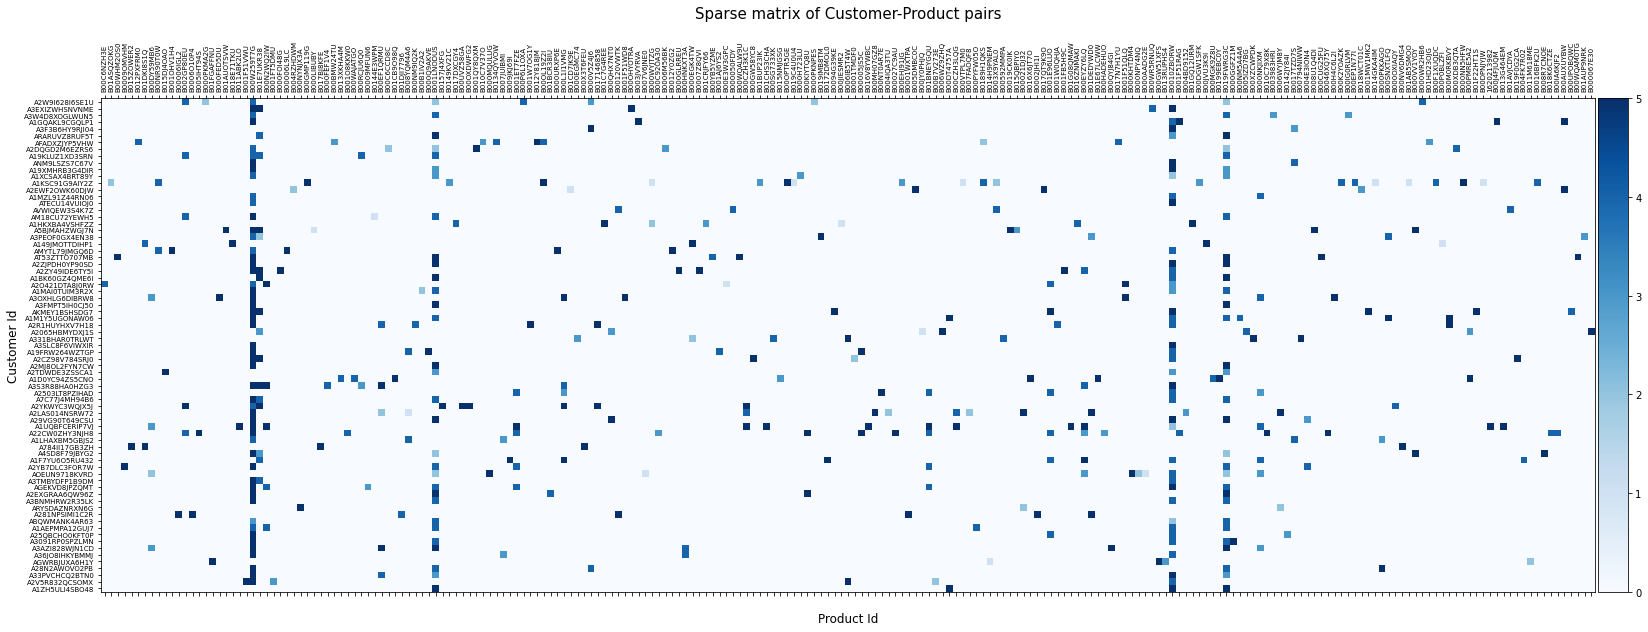

In [ ]:
# create sparse matrix of customer-product pairs and visualize it
df_sparse = pd.DataFrame(0, index=list(set(Text_Selected.index)), columns=list(set(Text_Selected['asin'])))
for i in range(len(Text_Selected)):
  df_sparse.loc[Text_Selected.index[i]][Text_Selected.iloc[i]['asin']] = Text_Selected.iloc[i]['overall'].astype('float')

## auxiliary function to plot matrix
def plt_mat(df_sparse):
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(23, 70));
  im = ax.matshow(df_sparse, cmap='Blues')
  plt.xticks(ticks=range(0, df_sparse.shape[1], 1), labels=list(df_sparse.columns), rotation='vertical', fontsize=7);
  plt.yticks(ticks=range(0, df_sparse.shape[0], 1), labels=list(df_sparse.index), fontsize=7)
  plt.xlabel("Product Id", fontsize=12, labelpad=20)
  plt.ylabel("Customer Id", fontsize=12)
  plt.title("Sparse matrix of Customer-Product pairs", fontsize=15, y=1.15)

  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="2%", pad=.05)
  plt.colorbar(im, cax=cax)
  plt.tight_layout()
  plt.show()

plt_mat(df_sparse)

*   The Customer-Product pairs matrix is rather sparse as each consumer will only make limited number of purchases, besides, it is clear that some of the products are welcomed by the majority consistent with our previous discovery. 
*   The depth of color indicates indivual's preference, thus to fill in the blank ones, it is reasonable to recommend goods bought by others with tastes alike, essential for maximizing business returns since similar people are more likely make the same choices.

### Cluster Customers with LDA on Reviews


In [ ]:
# recognize customers' main focuses and perform collaborative filtering in clusters
count_vectorizer = CountVectorizer(stop_words = 'english') ## count words for customers' corpus
count_data = count_vectorizer.fit_transform(Copora_final['Copora'])

## helper function for printing words combination for each topic
def print_topics(model, count_vectorizer, n_top_words):
  words = count_vectorizer.get_feature_names()
  for topic_idx, topic in enumerate(model.components_):
    print("\nTopic #%d:" % topic_idx)
    print(" ".join([words[i] for i in topic.argsort()[:-n_top_words-1 : -1]]))

## fit LDA model and obtain the topics distribution for each customer
number_topics = 3
number_words = 10
lda = LDA(n_components=number_topics)
lda.fit(count_data)
topic_customer = lda.transform(count_data)
print_topics(lda, count_vectorizer, number_words)

## cluster customers into groups
kmeans = KMeans(n_clusters=3, random_state=0).fit(topic_customer)
Copora_final['labels'] = list(kmeans.labels_)


Topic #0:
like use skin just product really hair bit don soap

Topic #1:
skin like just soap use good great scent hair nice

Topic #2:
like soap nice skin scent use good lavender color just


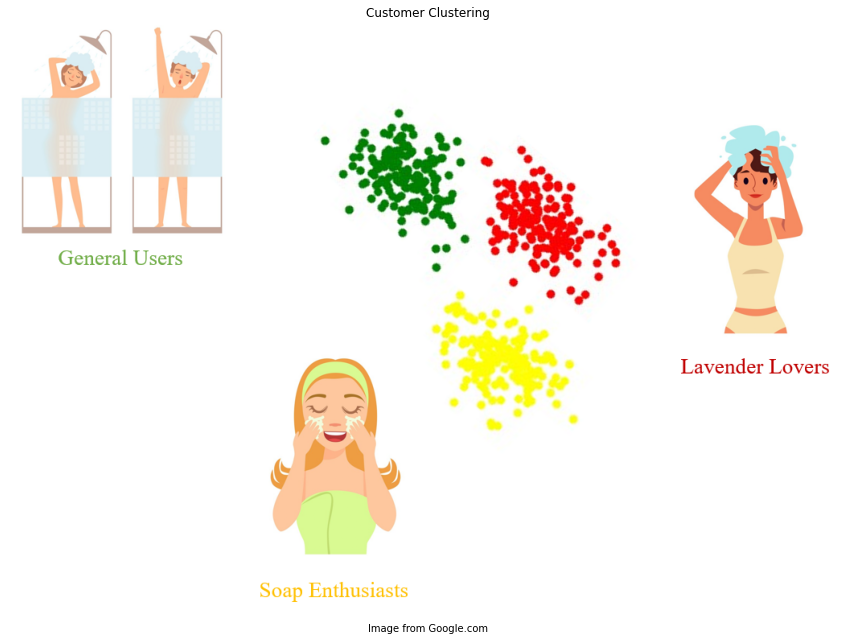

In [ ]:
#@title
rcParams['figure.figsize'] = 12, 12

img_A = mpimg.imread('./drive/My Drive/Amazon_All_Beauty/customer clustering.PNG');
fig, axes = plt.subplots(1, 1, figsize=(12, 10));
axes.imshow(img_A);
axes.axis('off');
axes.set_title('Customer Clustering');
fig.text(0.5, 0.06, 'Image from Google.com', ha='center');
plt.tight_layout()

*   Latent Dirichlet Allocation(LDA) extracted topics from the corpus in the form of combination of words, the resulting three topics could be summarized as customers with distinct features: 
  *   General users, who mainly care about the basic properties of the products so words like 'use', 'hair', 'skin' and 'scent' constitute the topic's major part.
  *   Soap enthusiasts, who have a preference to soaps and particularly pay attention to skin's caring, as some brands and products are specialized in such area, it is fair to cluster these customers into the same group for targeting recommendation.
  *   Lavender enthusiasts, who expressly fancy the flavor of lavender and consider more on skin health, less important for them whether it is a soap or cream but vital the scent is to their taste.
*   Thereafter, the model is applied on each customer's copora to decide his/her characteristic made up of the three features defined, for instance: **@Glenda Boozer = 0.1*General Users + 0.4*Soap Enthusiasts + 0.5*Lavender Lovers**
*   The customers with three attributes could now be clustered by K-Means which unsupervisedly gathers data into groups with the closest distances. It would be more efficient to make recommendation within the groups since they have alike needs or requests.



In [ ]:
## extract reviewerIDs for each group
Copora_final = Copora_final.reset_index()

groups = Copora_final.groupby(['labels'], as_index=False).agg({'reviewerID': ' '.join}).set_index(['labels'])
groups_dict = {key: [] for key in [0, 1, 2]}
for i in range(3):
  groups_dict[i] = groups.loc[i]['reviewerID'].split()

### Collaborative Filtering Recommendation with SVD

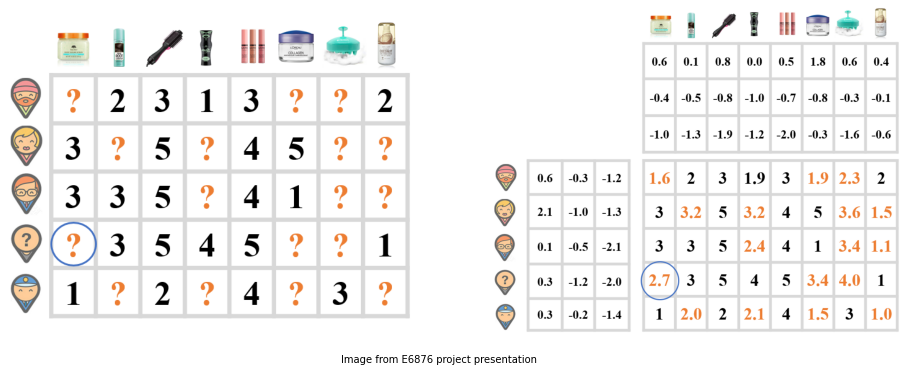

In [ ]:
#@title
rcParams['figure.figsize'] = 16, 12

img_A = mpimg.imread('./drive/My Drive/Amazon_All_Beauty/SVD.PNG');
img_B = mpimg.imread('./drive/My Drive/Amazon_All_Beauty/MF.PNG');
fig, ax = plt.subplots(1, 2);
ax[0].imshow(img_A);
ax[0].axis('off');
ax[1].imshow(img_B);
ax[1].axis('off');
fig.text(0.5, 0.28, 'Image from E6876 project presentation', ha='center');

*   To fill in the extremely sparse matrix, famous SVD algorithm is to be utilized of which a user matrix and an item matrix are constructed by Stochastic Gradient Descent(SGD) to approximate the existing scores as close as possible:
  *   SVD: $M = U\sum V^* = UI$
  *   Objective function: 
  $min\sum_{(i,j)\in M}(M_ij - U_iI_j)^2 + \lambda(||  U_i||^2 + ||I_j||^2)$
  *   Optimize by SGD: 
  $U_i \leftarrow U_i + \gamma(e_ijI_j - \lambda U_i),   I_j \leftarrow I_j + \gamma(e_ijU_i - \lambda I_j)$
*   The two generating matrices store latent factors and the corresponding user-item score is the result of dot production of the corresponding vectors, for example, **@Glenda Boozer** put emphasis on 'functionality', 'scent', 'appearance' with $0.7, 0.2, 0.1$ and the 'Waterpik' is rated respectively $4.9, 0, 4.1$ then it will be scored $0.7*4.9 + 0.2*0 + 0.1*4.1 = 3.84$ 

RMSE: 1.3231784337010857


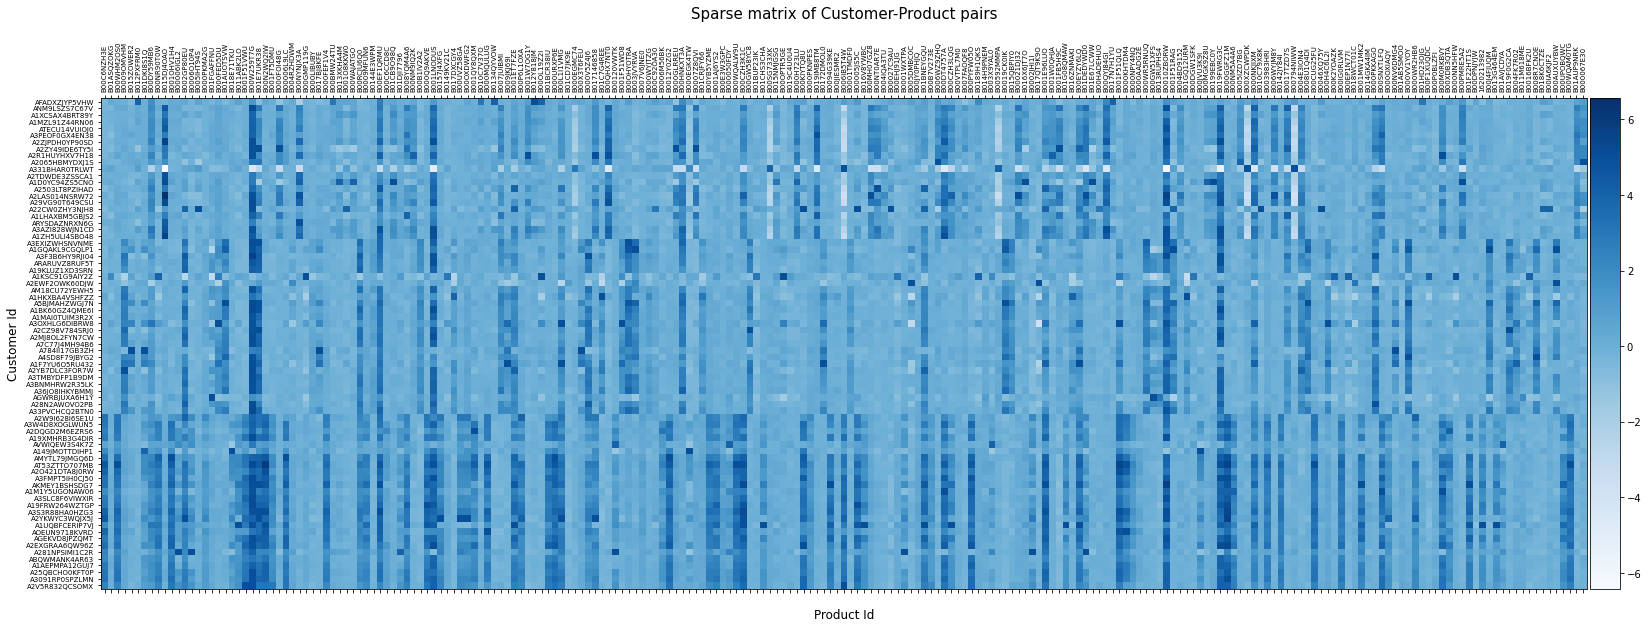

In [ ]:
## auxiliary function to perform SVD 
def reviewSVD(n_epochs, lr, n_factors, df_sparse):
    n_users = len(df_sparse.index)
    n_items = len(df_sparse.columns)

    ## initialize user matrix p and item matrix q
    p = np.random.normal(0, .1, (n_users, n_factors))
    q = np.random.normal(0, .1, (n_items, n_factors))

    ## decompose the sparse matrix into user and item factor matrix by SGD
    for _ in range(n_epochs):
        for u in range(len(df_sparse.index)):
            for i in range(len(df_sparse.columns)):
                if df_sparse.iloc[u, i] > 0:
                    err = df_sparse.iloc[u, i] - np.dot(p[u], q[i])
                    p[u] += lr * err * q[i]
                    q[i] += lr * err * p[u]

    ## reconstruct the user-item matrix
    df_recon = np.matmul(p, q.transpose())
    return df_recon

## make recommendation for each group and integrate the results
true_list = []
pred_list = []
df_reconstruct = pd.DataFrame(columns=df_sparse.columns)
for i in range(3):
  group0 = Text_Selected[Text_Selected.index.isin(groups_dict[i])].copy() ## select the target group and corresponding utility matrix
  df_sparse0 = df_sparse[df_sparse.index.isin(groups_dict[i])]

  df_train = df_sparse0.copy() ## mask the test set
  trainID, testID = sklearn_split(group0, test_size=.001, random_state=3)
  for n in range(len(testID.index)):
    df_train.loc[testID.index[n]][testID.iloc[n]['asin']] = 0

  n_epochs = 100
  lr = .01
  n_factors = 10
  nd_recon = reviewSVD(n_epochs, lr, n_factors, df_train)
  df_recon = pd.DataFrame(data=nd_recon, index=df_sparse0.index, columns=df_sparse0.columns)
  df_reconstruct = pd.concat([df_reconstruct, df_recon])

  for idx in range(len(testID.index)):
    true_list.append(testID['overall'].iloc[idx])
    pred_list.append(df_recon.loc[testID.index[idx]][testID.iloc[idx]['asin']])
print('RMSE:', np.sqrt(mean_squared_error(true_list, pred_list)))
plt_mat(df_reconstruct)

In [ ]:
# set Simon Funk's Matrix Factorization as the benchmark
reader = Reader(rating_scale=(1, 5)) ## define a reader for load dataframe

Customer_Product = Text_Selected[['asin', 'overall']] ## load dataframe
Customer_Product = Customer_Product.reset_index()
data = Dataset.load_from_df(Customer_Product, reader)
trainset, testset = train_test_split(data, test_size=.001)

SimonFunkMF = SVD(n_epochs=100, lr_all=.01, n_factors=10) ## apply MF and evaluate
SimonFunkMF.fit(trainset)
predictions = SimonFunkMF.test(testset)

accuracy.rmse(predictions)

RMSE: 1.9453


1.9453377076402756

*   The benchmark's RMSE is 1.95 meaning that the predicted score is approximately skewed 2 points, no doubt a poor result with regard to the scale of 1~5, recommendation would not be accurate and effective with such mechanism.
*   However the model solely focus on the ratings without leveraging the abundant review texts that might include information on what features the customer is specially interested in. 
*   After incorporating reviews for recognizing customers' focuses and clustering, the conditioned SVD achieves RMSE of 1.3, about 32% bettert than that of benchmark, with which a relatively accurate recommendation could be made and expects to help lift the click rate.

## Conclusion
*   In this User Growth project, a thorough method is proposed and implemented on the loyal customers:  
  *   Loyalty is measured by our modified RFML model which make classification based on the purchasing behavior;
  *   Two classical models Poisson Process and Hidden Markov Model are applied on consumers' consumption timeline to predict their further activities so that the efficiency of advertisements and promotions could be maximized by concentrating on targeted days;
  *   To precisely cater to individual's taste, a reviews-based recommendation system is built by first extracting personal focus from reviews then performing Singular Value Decomposition to fill in the sparse utility matrix, thereafter customized products could be recommended.
*   Each customer with distinct behavior pattern and preference would be provided personalized service that better meets his/her interest, for instance:
  *   Loyal customers & Lavender Lovers: special calls asking their opinions and delivering free samples of new Lavender scent products illustrate the meticulous cares they deserve; 
  *   Potential customers & Soap Enthusiasts: intense ads pushing related to soaps and product evaluations would stimulate them to figure out their favorite genres therefore with more possibility to be converted to the loyal ones;
  *   One-time customers & General Users: strong encouragements like coupons and free shipping could be offerred to increase the times of transactions after which more dedicated efforts would be put on those response actively.






## Acknowledgement
It is my first time to combine an engineering course project with the proposal from a business competition, as an engineer, years have I spent on optimized implementation of electronics and optics theories but never have I complete tasks of which designs are from top to down. The initial proposal is to make a customized recommendation system while we have relatively weak understanding of the process of collaborative filtering, it is when I took E6876 that topics on dealing with sparse matrix that a subtle structure pop into my mind. Afterwards, I started working on our top-to-down plan and here it is. The unexpected Covid-19 turned this semester into my last staying, nights and stars will I remember in this most fabulous campus on the Morningside Heights and wish good luck to myself and all my friends to the forwards unknown.